### Load Packages and Data

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [34]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [35]:
housing.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [36]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

### Ordinal encoding data

In [37]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Train Test Split

In [38]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [39]:
print(X_train.shape)
print(X_test.shape)

(2046, 62)
(512, 62)


<IPython.core.display.Javascript object>

### Model Scoring Function

In [40]:


def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)




<IPython.core.display.Javascript object>

### Random Tree Regression

In [41]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)


--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8962459717714694
Average MAE score: 14961.556414693212
--------------------------------------------------


<IPython.core.display.Javascript object>

### Feature Selection and Optimizing Number of Features

In [42]:

# 
# from sklearn.model_selection import cross_val_score

np.random.seed(42)

def feature_importance(model, X, y):
    model.fit(X, y)
    return sorted(zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True)

def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]
    
    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1)
        scores.append((i, np.mean(score)))

    return scores

def plot_scores(scores):
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=29, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")

    plt.show()




<IPython.core.display.Javascript object>

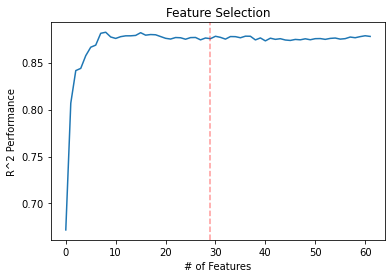

<IPython.core.display.Javascript object>

In [44]:

model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)
plot_scores(scores)


In [47]:
def plot_feature_importance(model, X_train, n_features=35):
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot
    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")
    plt.show()



<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

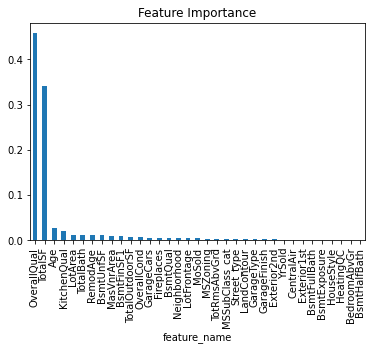

<IPython.core.display.Javascript object>

In [48]:
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)
plot_feature_importance(random_forest_model, X_train, n_features=35)


## Comparing Models of Optimal Features Vs All Features

In [49]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    # All features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Optimal features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]
    
    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    return all_features_score, optimal_features_score




<IPython.core.display.Javascript object>

In [50]:
model = RandomForestRegressor(random_state=0)
optimal_features_count = 29  # This from the plot_scores function
all_features_score, optimal_features_score = compare_models(
    model, X_train, y_train, X_test, y_test, optimal_features_count
)

print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)

R^2 score using all features:  0.9101409579414029
R^2 score using optimal features:  0.9098519833873219


<IPython.core.display.Javascript object>

The scores show that using all features is best and this is also what the plot shows

## Checking for Overfitting by Looking at the Train and Test Errors

In [53]:


def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)





<IPython.core.display.Javascript object>

In [54]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 84864780.89919
The test     error (MSE) is: 532073046.11335
The training R^2 is: 0.98464
The test     R^2 is: 0.91014


<IPython.core.display.Javascript object>

Model is overfitting

# Tuning the Hyper Parameters

In [56]:

def find_best_params(X_train, y_train):
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    # Create a RandomForestRegressor object
    rf = RandomForestRegressor(random_state=0)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

best_params = find_best_params(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(best_params)

# Create and fit a RandomForestRegressor model with the best parameters found
best_rf = RandomForestRegressor(**best_params, random_state=0)
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found by GridSearchCV:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
The training error (MSE) is: 85775615.50893
The test     error (MSE) is: 567413664.76211
The training R^2 is: 0.98448
The test     R^2 is: 0.90417


<IPython.core.display.Javascript object>

# Trying ensemble learning to increase test score

In [58]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def ensemble_predict(models, X):
    predictions = np.column_stack([model.predict(X) for model in models])
    return np.mean(predictions, axis=1)

# Fit RandomForestRegressor and GradientBoostingRegressor models with the best parameters
rf = RandomForestRegressor(**best_params, random_state=0)
gb = GradientBoostingRegressor(random_state=0)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Ensemble the two models
ensemble_models = [rf, gb]

# Calculate the mean squared error and R^2 for the train and test sets
mse_train_ensemble = mean_squared_error(y_train, ensemble_predict(ensemble_models, X_train))
mse_test_ensemble = mean_squared_error(y_test, ensemble_predict(ensemble_models, X_test))

r2_train_ensemble = r2_score(y_train, ensemble_predict(ensemble_models, X_train))
r2_test_ensemble = r2_score(y_test, ensemble_predict(ensemble_models, X_test))

print("The training error (MSE) with ensemble learning is: %.5f" % mse_train_ensemble)
print("The test     error (MSE) with ensemble learning is: %.5f" % mse_test_ensemble)
print("The training R^2 with ensemble learning is: %.5f" % r2_train_ensemble)
print("The test     R^2 with ensemble learning is: %.5f" % r2_test_ensemble)


The training error (MSE) with ensemble learning is: 107283707.66711
The test     error (MSE) with ensemble learning is: 478286883.87676
The training R^2 with ensemble learning is: 0.98058
The test     R^2 with ensemble learning is: 0.91922


<IPython.core.display.Javascript object>

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_fe

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=Non

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_f

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, 

## Does Dealing with High Cardinality Help?

In [67]:
housing = pd.read_csv("../data/housing_bins.csv")

<IPython.core.display.Javascript object>

In [68]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [69]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)


--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8927645586567715
Average MAE score: 15181.331663061374
--------------------------------------------------


<IPython.core.display.Javascript object>

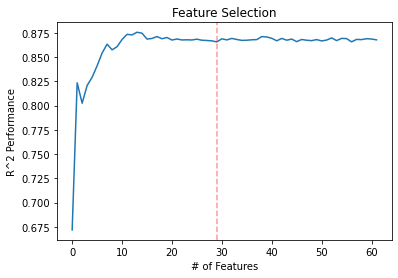

<IPython.core.display.Javascript object>

In [70]:
model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)
plot_scores(scores)


In [71]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 88762521.31457
The test     error (MSE) is: 590609744.33802
The training R^2 is: 0.98394
The test     R^2 is: 0.90026


<IPython.core.display.Javascript object>

In [72]:
# Fit RandomForestRegressor and GradientBoostingRegressor models with the best parameters
rf = RandomForestRegressor(**best_params, random_state=0)
gb = GradientBoostingRegressor(random_state=0)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Ensemble the two models
ensemble_models = [rf, gb]

# Calculate the mean squared error and R^2 for the train and test sets
mse_train_ensemble = mean_squared_error(
    y_train, ensemble_predict(ensemble_models, X_train)
)
mse_test_ensemble = mean_squared_error(
    y_test, ensemble_predict(ensemble_models, X_test)
)

r2_train_ensemble = r2_score(y_train, ensemble_predict(ensemble_models, X_train))
r2_test_ensemble = r2_score(y_test, ensemble_predict(ensemble_models, X_test))

print("The training error (MSE) with ensemble learning is: %.5f" % mse_train_ensemble)
print("The test     error (MSE) with ensemble learning is: %.5f" % mse_test_ensemble)
print("The training R^2 with ensemble learning is: %.5f" % r2_train_ensemble)
print("The test     R^2 with ensemble learning is: %.5f" % r2_test_ensemble)

The training error (MSE) with ensemble learning is: 123640991.47854
The test     error (MSE) with ensemble learning is: 481819518.87398
The training R^2 with ensemble learning is: 0.97762
The test     R^2 with ensemble learning is: 0.91863


<IPython.core.display.Javascript object>

#### Looks like using bins to deal with high cardinality didnt improve the test score but it did reduce the overfitting in the training score

# Using Shap to look at the features that contributed the most to the SalePrice

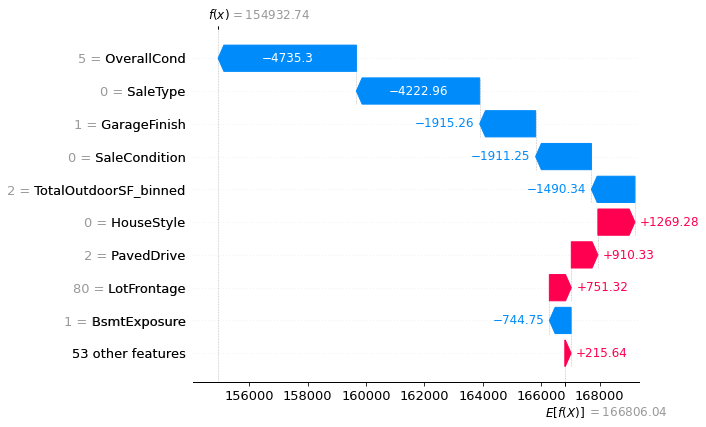

<IPython.core.display.Javascript object>

In [79]:


# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 0
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
shap.plots.waterfall(shap_values_instance[0])

